In [1]:
import numpy as np
import random
from IPython.display import clear_output
import time
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from tqdm.notebook import tqdm
import math

In [2]:
class Obstacle:
    
    def __init__(self,speed,angle,x,y,rows,cols):
        self.speed = speed
        self.angle = angle
        self.x = x
        self.y = y
        self.rows = rows
        self.cols = cols
    
    def move(self):
        if self.x == 0 or self.y == 0 or self.x == self.rows-1 or self.y == self.cols-1:
            self.speed *= -1
        self.x = self.x + self.speed * math.cos(self.angle*(math.pi/180))
        self.y = self.y + self.speed * math.sin(self.angle*(math.pi/180))

class GridEnv:
    
    def __init__(self,rows=None,cols=None,block_prob=0.1,grid=[]):
        if len(grid) > 0:
            self.grid = np.array(grid)
            self.rows = len(self.grid)
            self.cols = len(self.grid[0,:])
            self.block_prob = None
        else:
            self.rows = rows
            self.cols = cols
            self.block_prob = block_prob

        # Top = 0
        # Bottom = 1
        # Left = 2
        # Right = 3
        # Top-left = 4
        # Top-right = 5
        # Bottom-left = 6
        # Bottom-right = 7
        self.dx = [-1,0,1,0,1,1,-1,-1]
        self.dy = [0,1,0,-1,1,-1,1,-1]
        
        self.c_x = []
        self.c_y = []
        self.pheromone_list = np.zeros((self.rows,self.cols))
        
        self.obstacles = []
        self._generate_random_grid()
            
    def move_obstacles(self):
        for obstacle in self.obstacles:
            self.grid[obstacle.x,obstacle.y] = 0
            self._change_value(0,obstacle.x,obstacle.y)
            
            obstacle.move()
            
    
    def _change_value(self,value,x,y):
        for x,y in zip(self.dx,self.dy):
            newX = x + i
            newY = y + j
            if newX >= 0  and newY >= 0 and newX < self.rows and newY < self.cols: 
                self.grid[newX,newY] = value
    
    def dfs(self,pos,visited):
        if pos[0] == self.rows-1 and pos[1] == self.cols-1:
            return True
        visited[pos[0],pos[1]] = 1
        found = False
        for x,y in zip(self.dx,self.dy):
            newX = pos[0] + x
            newY = pos[1] + y
            if newX < 0 or newX == self.rows or newY < 0 or newY == self.cols:
                continue
            elif self.grid[newX,newY] == 1:
                continue
            elif visited[newX,newY] == 0:
                found |= self.dfs((newX,newY),visited)
                if found:
                    return True
        return found
        
    def _generate_random_grid(self):
        done = False
        while not done:
            self.grid = np.zeros((self.rows,self.cols))
            for i in range(self.rows):
                for j in range(self.cols):
                    if (i==0 and j==0) or (i==self.rows-1 and j==self.cols-1):
                        continue
                    if random.random() < self.block_prob:
                        self.grid[i,j] = 1
                        self.obstacles.append(Obstacle(speed=1,angle=21,x=i,y=j,rows=self.rows,cols=self.cols))
                        self._change_value(1,i,j)
            # DFS
            visited = np.zeros((self.rows,self.cols))
            start = (0,0)
            done = self.dfs(start,visited)
    
    def _generate_figure(self):
        x = 5.0
        y = 5.0
        a = 10.0
        for i in range(0,self.rows):
            for j in range(0,self.cols):
                if self.grid[i,j] == 0:
                    plt.gca().add_patch(patches.Rectangle((x, y),a,a,fill = False))
                    self.c_x.append(x+5.0)
                    self.c_y.append(y+5.0)
                else:
                    plt.gca().add_patch(patches.Rectangle((x, y),a,a))
                    self.c_x.append(x+5.0)
                    self.c_y.append(y+5.0)
                x = x + 10.0
            y = y - 10.0
            x = x - (j+1)*10.0
    
    def plot(self,best):
        self._generate_figure()
        path_x = []
        path_y = []
        for k in range(0,len(best)):
            path_x.append(self.c_x[best[k]])
            path_y.append(self.c_y[best[k]])
            
        for i in range(0,len(self.c_x)):
            if i in best:
                plt.scatter(self.c_x[i],self.c_y[i],c = "black")
        plt.plot(path_x,path_y,'k')
    
    def give_possible_steps(self, currX, currY, visited):
        feasable = []
        for x,y in zip(self.dx,self.dy):
            newX = currX + x
            newY = currY + y
            # if len(visited) > 1:
            #     print(newX,newY,visited[-1],visited[-2])
            
            # Out of bounds
            if newX < 0 or newY < 0 or newX >= self.cols or newY >= self.rows:
                continue
            # Blocked
            elif self.grid[newX][newY] == 1:
                continue
            # dont go back
            elif len(visited) > 1 and (newX,newY) == visited[-2]:
                continue
            feasable.append((newX,newY))
        return feasable
    
    def render(self,x,y):
        for i in range(self.rows):
            print(':',end='')
            for j in range(self.cols):
                if x == i and y == j:
                    print('#',end=':')
                elif (i == 0 and j == 0) or (i == self.rows-1 and j == self.cols-1):
                    print('$',end=':')
                elif self.grid[i,j] == 1:
                    print('0',end=':')
                else:
                    print(' ',end=':')
            print()
            if i != self.rows-1:
                print(' ',end='')
                for j in range(self.cols):
                    print('-',end=' ')
                print()

class Ant:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.ant_x = 0
        self.ant_y = 0
        self.ant_path_length = 0
        self.visited = [(0,0)]
    
    def reached_goal(self,goal):
        return self.ant_x == goal[0] and self.ant_y == goal[1]

In [9]:
env = GridEnv(rows=10,cols=10,block_prob=0.08)
env.render(0,0)

:#: : : : : : : : : :
 - - - - - - - - - - 
: : : : : : : : : : :
 - - - - - - - - - - 
:0: : : : :0: : :0: :
 - - - - - - - - - - 
: : : : : :0: : : : :
 - - - - - - - - - - 
: : : : : : : : : : :
 - - - - - - - - - - 
: : : : : : : : : : :
 - - - - - - - - - - 
: : : : : :0: : : : :
 - - - - - - - - - - 
: : : : : : : : : : :
 - - - - - - - - - - 
: : : : : : : : : :0:
 - - - - - - - - - - 
: : : : :0: : : : :$:


In [229]:
num_iterations = 500
best = []
alpha = 0.7
beta = 0.3
gamma = 0.2
num_ants = 7
ants = [Ant() for _ in range(num_ants)]

def get_distance(a,b):
    return math.sqrt(math.pow((a[0]-b[0]),2) + math.pow((a[1]-b[1]),2))

def roulette_wheel(probs):
    wheel = []
    for index in range(len(probs)):
        val = probs[index]
        cycles = val * 360
        for _ in range(int(cycles)):
            wheel.append(index)
    return wheel[random.randint(0,len(wheel)-1)]

In [230]:
env.pheromone_list = np.zeros((env.rows,env.cols))
best = []

for i in tqdm(range(num_iterations)):
    done = False
    for ant in ants:
        ant.reset()
    while not done:
        temp = True
        for ant in ants:
            if ant.reached_goal((env.rows-1,env.cols-1)):
                continue
            next_steps = env.give_possible_steps(ant.ant_x,ant.ant_y,ant.visited)
            prob = []
            for step in next_steps:
                dist = 1/get_distance((ant.ant_x,ant.ant_y),step)
                pheromone = env.pheromone_list[step[0]][step[1]]
                prob.append(math.pow(dist,alpha)*math.pow(pheromone,beta))
            total_prob = sum(prob)
            choice = ()
            # if all cells has no pheromones then do a random choice
            if total_prob == 0:
                choice = random.choice(next_steps)
            else:
                prob = [p/total_prob for p in prob]
                # choice = next_steps[np.argmax(prob)]
                choice = next_steps[roulette_wheel(prob)]
            ant.ant_x = choice[0]
            ant.ant_y = choice[1]
            ant.visited.append(choice)
            temp = temp and ant.reached_goal((env.rows-1,env.cols-1))
        done = temp
            
    # Calculate the Q value
    # length_list = [len(ant.visited) for ant in ants]
    # max_length = max(length_list)
    # length_list = [(max_length - l + 1) for l in length_list]
    # total_length = sum(length_list)
    # q_values = [9*(length/total_length) for length in length_list]
    q_values = [1 for ant in ants]
    
            
    # Pheromone is updated after solution of all ants
    pheromones_per_grid_cell = {}
    for i in range(len(ants)):
        ant = ants[i]
        Q = q_values[i]
        ant_path_length = len(ant.visited)
        if len(best) == 0 or ant_path_length < len(best):
            best = ant.visited
        for step in ant.visited:
            if step not in pheromones_per_grid_cell.keys():
                pheromones_per_grid_cell[step] = Q/ant_path_length
            else:
                pheromones_per_grid_cell[step] += Q/ant_path_length

    for step in pheromones_per_grid_cell.keys():
        curr_pher = env.pheromone_list[step[0]][step[1]]
        curr_pher = (1-gamma)*curr_pher + pheromones_per_grid_cell[step]
        env.pheromone_list[step[0]][step[1]] = curr_pher
    
print(f"Iteration {i+1}: Path Length = {len(best)}")

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 7: Path Length = 14


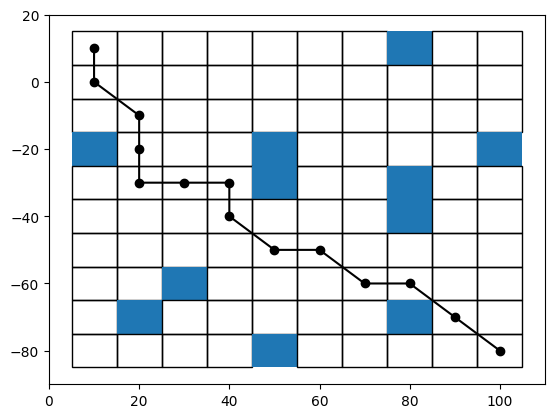

In [232]:
print(best)
temp_list = [x[0]*env.rows+x[1] for x in best]
env.plot(temp_list)

In [12]:
import math

math.sin(math.pi/6)

0.49999999999999994